In [15]:
from __future__ import division
%pylab inline
import numpy as np
import scipy.spatial.distance as dist
from scipy import stats
import pickle
import math
import collections
import numpy as np


from sklearn.lda import LDA

Populating the interactive namespace from numpy and matplotlib


C:\Users\123\Anaconda2\lib\site-packages\sklearn\lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


================================================================
bullet one starts from here
================================================================

In [ ]:
# combination of 8 y/n
# sequence = label
# 1 = yes, 0 = no

# each dataset has shape 25 x 150


In [1]:
import glob
import numpy as np

In [2]:
def readFiles():
    files = glob.glob("training/*.txt")

    
    #threshold is the start of the slicing
    #set threshold to converge the best solution
    
    # 1 = yes, 0 = no
    
    training0 = []    # 25 * 10 for each sample and space 3 lines
    training1 = []  
    
    for fileName in files:
        with open(fileName) as file_:
            # fileName get label 
            labels = fileName[9:-4].split("_")
            # zero padding = [3, 10]
            
            padding = np.zeros(shape = (3, 10))
            
#             print len(labels)
            threshold = 1
            

            
            # slicing it and seperate into yes_train and no_train
            # " " = high   =  1
            # "%" = low    =  0
            rawdata = np.zeros(shape = (25,150))
            counter = 0 # count num of lines
            for line in file_:
                for i in range(len(line)-1):
                    if line[i] == " ":
                        rawdata[counter][i] = 1
                counter += 1
            
            
            newstart = 0
            num_slicing = 0
            
            for cow in range(len(line)-1):
                if num_slicing >= 8:
                    break
                if cow < newstart:
                    continue
                if np.sum(rawdata[:,cow]) > threshold:
                    #start slicing
#                     print num_slicing
                    if labels[num_slicing] == "0":   #no                        
                        if len(training0) == 0:
                            training0 = rawdata[:,cow:cow+10]
                        else:
                            training0 = np.concatenate( (training0,rawdata[:,cow:cow+10]),  axis = 0)
                        
                        training0 = np.concatenate( (training0,padding),  axis = 0)
                    else:
                        if len(training1) == 0:
                            training1 = rawdata[:,cow:cow+10]
                        else:
                            training1 = np.concatenate( (training1,rawdata[:,cow:cow+10]),  axis = 0)                              
                        training1 = np.concatenate( (training1,padding),  axis = 0)
                    
                    newstart = cow + 10
                    
                    #after slicing
                    num_slicing += 1
#     print len(training0)/28, len(training1)/28
    return (training1,training0)   # (yes,no)


In [3]:
trainingdata = readFiles()

yes_num = len(trainingdata[0])/28
no_num = len(trainingdata[1])/28

print yes_num, no_num

251 229


In [27]:
#   yes is class 0
#   no is class 1
k = 0.35
    
def training(yes_train, no_train, yes_num, no_num):
    # " " = high   =  1
    # "%" = low    =  0
    
    class_total = [yes_num, no_num]

    training0 = np.zeros(shape=(2, 25, 10))   #low
    training1 = np.zeros(shape=(2, 25, 10))   #high

    count = 0
    for i in range(int(yes_num)):
        for row in range(25):
            for col in range(10):
                if yes_train[i*28 + row][col] == 1:   #high
                    training1[0][row][col] += 1
                    training0[0][row][col] += 0
                else:
                    training1[0][row][col] += 0
                    training0[0][row][col] += 1
                    
    for i in range(int(no_num)):
        for row in range(25):
            for col in range(10):
                if no_train[i*28 + row][col] == 1:   #high
                    training1[1][row][col] += 1
                    training0[1][row][col] += 0
                else:
                    training1[1][row][col] += 0
                    training0[1][row][col] += 1

    for i in range(2):
        training1[i] = (training1[i] + k) / (class_total[i] + k * 2)
        training0[i] = (training0[i] + k) / (class_total[i] + k * 2)
#     print(training0[1][0])
#     print(training1[1][0])
    
    return training0, training1

In [28]:
training0, training1 = training(trainingdata[0],trainingdata[1],yes_num,no_num)

In [ ]:
# print trainingYes

In [29]:
def readTestFiles(directory):
    padding = np.zeros(shape = (3, 10))    
    files = glob.glob(directory)
    
    testingdata = []
    
    for fileName in files:
        with open(fileName) as file_:
            sample = [list(line)[0:10] for line in file_]
        if len(testingdata) == 0:
            testingdata = sample
        else:
            testingdata = np.concatenate((testingdata,sample), axis = 0)
        testingdata = np.concatenate((testingdata,padding), axis = 0)

    return testingdata
        

In [30]:
test_no = readTestFiles("no_test/*.txt")
test_yes = readTestFiles("yes_test/*.txt")

In [13]:
Num_test_no = len(test_no) / 28
Num_test_yes = len(test_yes) / 28
print Num_test_no
print Num_test_yes


50
50


In [17]:
# log P(class) + log P(f1,1 | class) + log P(f1,2 | class) + ... + log P(f28,28 | class)

# test_rough = inputDigit(name = "digitdata/testimages")
def testing(yes_test, no_test, Num_test_yes, Num_test_no):

    data_test = np.concatenate( (yes_test, no_test) , axis = 0 )
# #     print len(data_test) / 28
#     return 

    total = Num_test_yes + Num_test_no
    answer = np.zeros(int(total))
    
    class_total = [Num_test_yes, Num_test_no]
    
    for i in range(int(total)):
        test_image = np.zeros(shape=(25,10))
        for row in range(25):
            for col in range(10):
                if data_test[i*28+row][col] == ' ':
                    test_image[row][col] = 1
                else:
                    test_image[row][col] = 0
                    

        posteriori = np.zeros(2)
        for class_num in range(2):
            posteriori[class_num] = math.log(class_total[class_num])
            for row in range(25):
                for col in range(10):
                    if test_image[row][col] == 0:
                        posteriori[class_num] += math.log(training0[class_num][row][col])
                    else:
                        posteriori[class_num] += math.log(training1[class_num][row][col] )   
        answer[i] = np.argmax(posteriori)
#     print answer
    return answer



In [18]:
def confusion_matrix(pred):
    conf_matrix = np.zeros(shape=(2,2))
    #print(conf_matrix[0][0])
    #print(int(answer[0]))
    for i in range(100):
        if i < 50:
            conf_matrix[0][int(pred[i])] += 1
        else:
            conf_matrix[1][int(pred[i])] += 1
            
    for i in range(2):
        for j in range(2):
            conf_matrix[i][j] /= 50.0
    
    return conf_matrix

In [31]:
# print confusion matrix
answer = testing(test_yes, test_no, Num_test_yes, Num_test_no)
conf_matrix = confusion_matrix(answer)
conf_matrix = np.around(conf_matrix, 2)
for row in conf_matrix:
    print(row)
overall_accuracy = 0
for i in range(2):
    overall_accuracy += conf_matrix[i][i] * 50.0
print("overall_accuracy = " + str(overall_accuracy/100))

[ 0.98  0.02]
[ 0.06  0.94]
overall_accuracy = 0.96


In [22]:
# Laplace smoothing constant
k1 = np.array([10**(-6), 10**(-5), 10**(-4), 0.001, 0.002, 0.005, 0.01, 0.02, 0.05])
k2 = np.linspace(0.1, 10, 100)
k_grid = np.append(k1, k2)

accuracy = np.zeros(109)

for k_index in range(109):
    k = k_grid[k_index]
    #print(k)
    training0, training1 = training(trainingdata[0],trainingdata[1],yes_num,no_num)
    answer = testing(test_yes, test_no, Num_test_yes, Num_test_no)
    conf_matrix = confusion_matrix(answer)
    overall_accuracy = 0
    for i in range(2):
        overall_accuracy += conf_matrix[i][i] * 50.0
        accuracy[k_index] = overall_accuracy
    print("accuracy =", overall_accuracy/100.0, "when k is ", k_grid[k_index])

('accuracy =', 0.94999999999999996, 'when k is ', 9.9999999999999995e-07)
('accuracy =', 0.94999999999999996, 'when k is ', 1.0000000000000001e-05)
('accuracy =', 0.94999999999999996, 'when k is ', 0.0001)
('accuracy =', 0.94999999999999996, 'when k is ', 0.001)
('accuracy =', 0.94999999999999996, 'when k is ', 0.002)
('accuracy =', 0.95999999999999996, 'when k is ', 0.0050000000000000001)
('accuracy =', 0.95999999999999996, 'when k is ', 0.01)
('accuracy =', 0.95999999999999996, 'when k is ', 0.02)
('accuracy =', 0.95999999999999996, 'when k is ', 0.050000000000000003)
('accuracy =', 0.95999999999999996, 'when k is ', 0.10000000000000001)
('accuracy =', 0.95999999999999996, 'when k is ', 0.20000000000000001)
('accuracy =', 0.95999999999999996, 'when k is ', 0.30000000000000004)
('accuracy =', 0.95999999999999996, 'when k is ', 0.40000000000000002)
('accuracy =', 0.95999999999999996, 'when k is ', 0.5)
('accuracy =', 0.95999999999999996, 'when k is ', 0.59999999999999998)
('accuracy ='

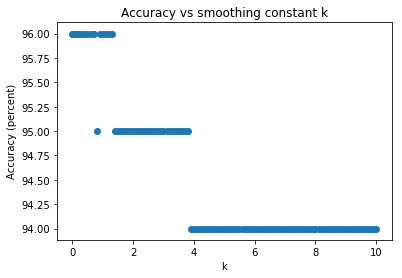

In [23]:
%matplotlib inline
plt.figure()
ax = plt.gca()
#ax.set_xscale('log')
plt.scatter(k_grid[5:], accuracy[5:], label = 'f(x)')
plt.xlabel("k")
plt.ylabel("Accuracy (percent)")
plt.title("Accuracy vs smoothing constant k")

In [26]:
# Laplace smoothing constant
k_grid = np.linspace(0.0001, 0.7, 60)

accuracy = np.zeros(60)

for k_index in range(60):
    k = k_grid[k_index]
    #print(k)
    training0, training1 = training(trainingdata[0],trainingdata[1],yes_num,no_num)
    answer = testing(test_yes, test_no, Num_test_yes, Num_test_no)
    conf_matrix = confusion_matrix(answer)
    overall_accuracy = 0
    for i in range(2):
        overall_accuracy += conf_matrix[i][i] * 50
        accuracy[k_index] = overall_accuracy
    print("accuracy =", overall_accuracy/100, "when k is ", k_grid[k_index])

('accuracy =', 0.94999999999999996, 'when k is ', 0.0001)
('accuracy =', 0.95999999999999996, 'when k is ', 0.011962711864406778)
('accuracy =', 0.95999999999999996, 'when k is ', 0.023825423728813556)
('accuracy =', 0.95999999999999996, 'when k is ', 0.035688135593220337)
('accuracy =', 0.95999999999999996, 'when k is ', 0.047550847457627117)
('accuracy =', 0.95999999999999996, 'when k is ', 0.059413559322033897)
('accuracy =', 0.95999999999999996, 'when k is ', 0.071276271186440671)
('accuracy =', 0.95999999999999996, 'when k is ', 0.083138983050847451)
('accuracy =', 0.95999999999999996, 'when k is ', 0.095001694915254231)
('accuracy =', 0.95999999999999996, 'when k is ', 0.10686440677966101)
('accuracy =', 0.95999999999999996, 'when k is ', 0.11872711864406779)
('accuracy =', 0.95999999999999996, 'when k is ', 0.13058983050847456)
('accuracy =', 0.95999999999999996, 'when k is ', 0.14245254237288132)
('accuracy =', 0.95999999999999996, 'when k is ', 0.15431525423728812)
('accuracy 

LDA
==============


In [32]:
from __future__ import division
%pylab inline
import numpy as np
import scipy.spatial.distance as dist
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


C:\Users\123\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [33]:
def readFiles():
    files = glob.glob("training/*.txt")

    
    #threshold is the start of the slicing
    #set threshold to converge the best solution
    
    # 1 = yes, 0 = no
    
    training0 = []    # 25 * 10 for each sample and space 3 lines
    training1 = []  
    
    for fileName in files:
        with open(fileName) as file_:
            # fileName get label 
            labels = fileName[9:-4].split("_")
            # zero padding = [3, 10]
            
            #padding = np.zeros(shape = (3, 10))
            
#             print len(labels)
            threshold = 1
            

            
            # slicing it and seperate into yes_train and no_train
            # " " = high   =  1
            # "%" = low    =  0
            rawdata = np.zeros(shape = (25,150))
            counter = 0 # count num of lines
            for line in file_:
                for i in range(len(line)-1):
                    if line[i] == " ":
                        rawdata[counter][i] = 1
                counter += 1
            
            
            newstart = 0
            num_slicing = 0
            
            for cow in range(len(line)-1):
                if num_slicing >= 8:
                    break
                if cow < newstart:
                    continue
                if np.sum(rawdata[:,cow]) > threshold:
                    #start slicing
#                     print num_slicing
#                     print rawdata[:,cow:cow+10].shape
                    if labels[num_slicing] == "0":   #no
                        temp_training0 = np.reshape(rawdata[:,cow:cow+10],(1,250))
                        if len(training0) == 0:
                            training0 = temp_training0
                        else:
                            training0 = np.concatenate( (training0,temp_training0),  axis = 0)
                        
#                         training0 = np.concatenate( (training0,padding),  axis = 0)
                    else:
                        temp_training1 = np.reshape(rawdata[:,cow:cow+10],(1,250))
                        if len(training1) == 0:
                            training1 = temp_training1
                        else:
                            training1 = np.concatenate( (training1,temp_training1),  axis = 0)                              
#                         training1 = np.concatenate( (training1,padding),  axis = 0)
                    
                    newstart = cow + 10
                    
                    #after slicing
                    num_slicing += 1
#     print len(training0)/28, len(training1)/28
    print training1.shape, training0.shape
    return (training1,training0)   # (yes,no)


In [34]:
trainingdata = readFiles()


(251L, 250L) (229L, 250L)


In [35]:
def trainLDA(trainfeat,trainlabel):
    nlabels=int(trainlabel.max())+1 #Assuming all labels up to nlabels exist.
    pi=np.zeros(nlabels) # store your prior in here
    means=np.zeros((nlabels,trainfeat.shape[1])) # store the class means in here
    cov=np.zeros((trainfeat.shape[1],trainfeat.shape[1])) # store the covariance matrix in here
    # Put your code here
    #print (pi.shape, means.shape, cov.shape)
    #nlabels = M
    for i in range(0, nlabels):
        pi[i] = float(np.sum(trainlabel==i)) / trainlabel.size
        
        for j in range(0, trainfeat.shape[0]):
            if int(trainlabel[j]) == i:
                means[i] += trainfeat[j] / float(np.sum(trainlabel==i))
            # means[i] = float(np.sum(trainfeat[trainlabel==i])) / np.sum(trainlabel==i) 
    
         
    
    for i in range(0, nlabels):
        for j in range(0,trainlabel.size):
            #cov += np.outer(trainfeat[trainlabel[j]==i] -  means[i], trainfeat[trainlabel[j]==i] -  means[i]) 
            if(trainlabel[j] == i):
                cov += np.outer(trainfeat[j] -  means[i], trainfeat[j] -  means[i]) 
    
    cov = cov /(trainlabel.size - nlabels )
    
    return (pi,means,cov)

In [36]:

trainfeat = np.concatenate((trainingdata[0],trainingdata[1]) , axis = 0 )
yes_label = np.zeros(yes_num)
no_label = np.ones(no_num)

trainlabel = np.concatenate((yes_label,no_label) , axis = 0 )


In [37]:
# Put your code here
LDAAttributes = trainLDA(trainfeat, trainlabel)

print("Pi : ")
print LDAAttributes[0].shape
print("Means : ")
print LDAAttributes[1].shape
print("Cov : ")
print LDAAttributes[2].shape
#print("Training error : ")


Pi : 
(2L,)
Means : 
(2L, 250L)
Cov : 
(250L, 250L)


In [38]:
from sklearn.lda import LDA
# Put your code here
LDA = LDA()
LDA.fit(trainfeat, trainlabel)

C:\Users\123\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA(n_components=None, priors=None, shrinkage=None, solver='svd',
  store_covariance=False, tol=0.0001)

In [39]:
def readTestFiles(directory):
#     padding = np.zeros(shape = (3, 10))    
    files = glob.glob(directory)
    
    testingdata = []
    
    for fileName in files:
        with open(fileName) as file_:
            sample = np.reshape([list(line)[0:10] for line in file_],(1,250))
        if len(testingdata) == 0:
            testingdata = sample
        else:
            testingdata = np.concatenate((testingdata,sample), axis = 0)
#         testingdata = np.concatenate((testingdata,padding), axis = 0)

    return testingdata
        

In [42]:
test_no = readTestFiles("no_test/*.txt")
test_yes = readTestFiles("yes_test/*.txt")

 

yes_label = np.zeros(50)
no_label = np.ones(50)

testlabel = np.concatenate((yes_label,no_label) , axis = 0 )

data_test = np.concatenate( (test_yes, test_no) , axis = 0 )
# print data_test.shape[0]

test_data = np.zeros(data_test.shape)

for i in range(data_test.shape[0]):
    for j in  range(data_test.shape[1]):        
        if data_test[i,j] == ' ':
            test_data[i,j] = 1
    

classification = LDA.predict(test_data)
error = classifierError(testlabel,classification)

print 1-error

0.88


In [41]:
def classifierError(truelabels,estimatedlabels):
    # Put your code here
    loss = 0
    for i in range(0,truelabels.size):
        if(truelabels[i] != estimatedlabels[i] ):
            loss = loss + 1
    
    return float (loss) / truelabels.size